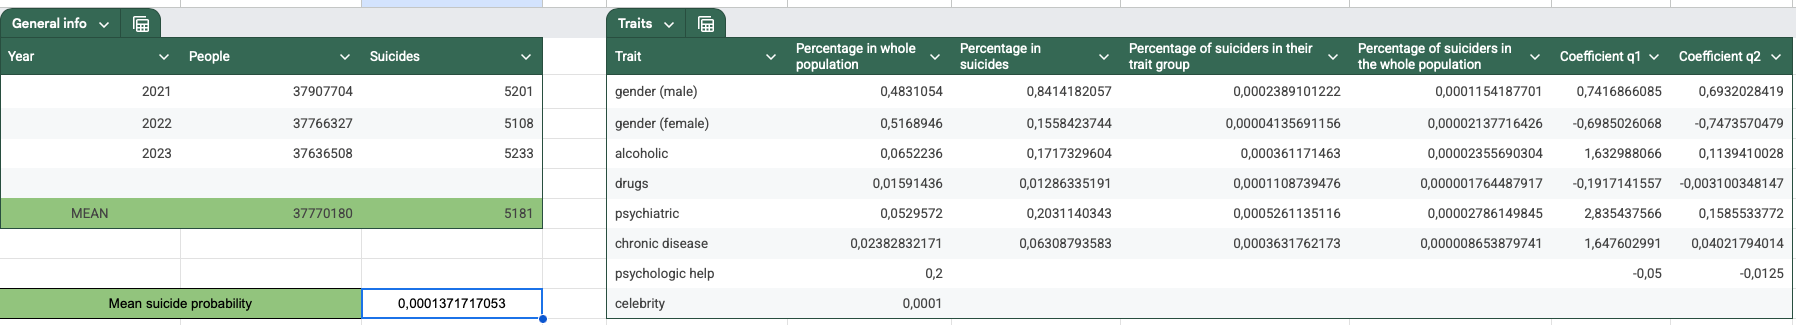

* liczba osob uzaleznionych od narkotykow na 2018 rok jest szacowana na 60k osob czyli mniej wiecej 0.015914359526600853 populacji

* liczba osob przewlekle chorych jest ciezka do ustalenia - dajemy 900k osób czyli prawie 2.38%

* liczba osob korzystajaca z pomocy psychologa - 20%

* celebrytom zostawiamy taka sama szanse na samobojstwo

Po pierwsze trzeba zdefiniować, jak będzie chcieli pogrupować społeczności (znajomych) względem agenta. Albo na sztywno robimy "patch", które będą oznaczać naszą społeczność, albo robimy jakiś clustering (ale nie brałbym wszystkich), albo jeszcze inny sposób.

Podstawowy sposób w jaki się generuje samobójstwa to bierze się wartości cech, dla każdej cechy ustala się wartość graniczną (threshold), której po przekroczeniu zwiększa się ryzyko popełnienia samobójstwa dla danej cechy. Czyli {1 - q, 1 + q}, gdzie q to ustalona wartość. 

Czyli parwdopodobieństwo popełnienia samobójstwa będzie równe 

$$ p_{new} = p_{old}\cdot\prod_{i=1}^{6}(1 \pm q_i)$$




Keywords:
- social learning

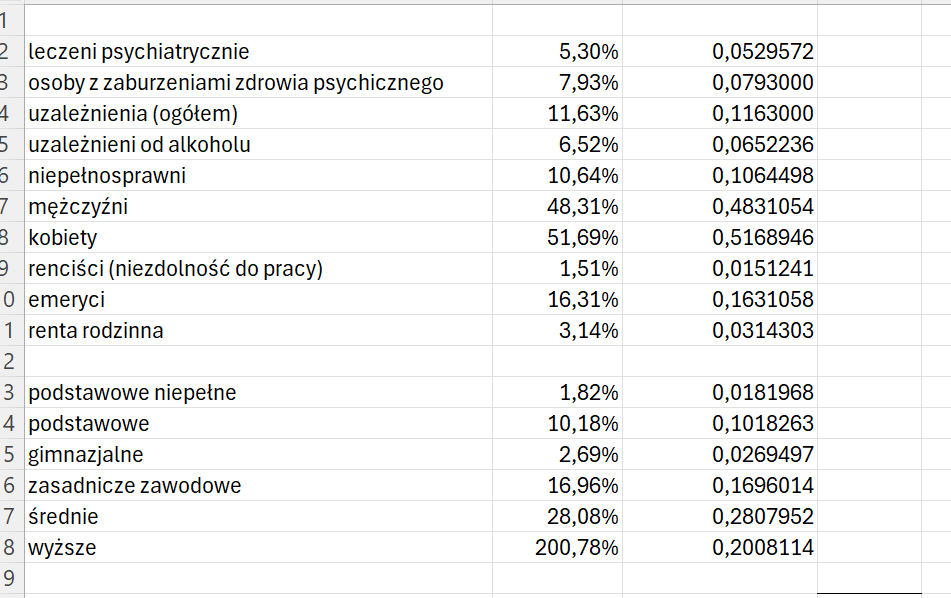

In [139]:
import numpy as np
import matplotlib.pyplot as plt

In [140]:
#gender (male), alcoholic, drugs, psychiatric, chronic disease, psychologic help, celebrity

traits_prob_binary = np.array([0.4831054, 0.0652236, 0.01591436, 0.0529572, 0.02382832171, 0.2, 0.0001])
q1 = np.array([0.7416866085, 1.632988066, -0.1917141557, 2.835437566, 1.647602991, -0.05, 0])
q2 = -1 * np.array([0.6932028419, 0.1139410028, -0.003100348147, 0.1585533772, 0.04021794014, -0.0125, 0])

In [141]:
class Community:

    def __init__(self, M, traits_prob_binary, q1, q2, memory_time = 3):
        self.M = M     # M is size of patch
        self.q1 = q1
        self.q2 = q2
        self.memory_time = memory_time
        self.patch = np.zeros(shape = (M, len(traits_prob_binary) + 2), dtype=object)  # community patch
        self.traits_prob_binary = traits_prob_binary
        self.obituary = []
        self.world_obituary = []
        self.time = 0
        
    def _agents_stats(self):
        # draw binary stats according to stats_prob array
        # TODO dodac czynnik losowy
        # teraz zakładam, że te staty dla agentów są stałe, i tylko na początku są losowane
        suicide_prob = lambda stats: stats[0] * np.prod(1 + np.array([self.q1[i] if stat==1 else self.q2[i] for i, stat in enumerate(stats[2:])]) )
        agent = np.array([1.1 * 10**(-5)] + [self.time] + [1 if np.random.uniform()<prob else 0 for prob in self.traits_prob_binary])
        agent[0] = suicide_prob(agent)
        return agent
    
    def _fill_community(self):
        # if stat==1 then multiply p0 by 1 + value from q1_list
        # elif stat==0 then multiply p0 by 1 - value from q2_list which is already *(-1) so 1 + value from q2_list
        

        # add agent to community
        self.patch[0] = self._agents_stats()
        for i in range(1,self.M):
            if np.random.random() < 0.3:
                self.patch[i] = self.patch[0]
            else:
                self.patch[i] = self._agents_stats()

    def _suicide_status(self, probability_of_suicide):

        suicidal_index = []
        suicidal_cele = []
        for i in range(self.M):

            if np.random.binomial(1,probability_of_suicide[i]) == 1:
                suicidal_index.append(i) 

                if self.patch[i][-1] == 0:
                    self.obituary.append(self.patch[i][1:])

                else:
                    suicidal_cele += self.patch[i][1:].tolist()
        
        return suicidal_cele, suicidal_index
    

    def _copycat_suicide(self, suicidal_cele):

        if len(suicidal_cele) > 0:
            self.world_obituary += suicidal_cele
        
        suicidal = self.world_obituary
        now_prob = []
        celebrities = []

        if len(suicidal) > 0:
            for j in range(self.M):
                xn = []
                xs = []

                for stats in suicidal:

                    # this check if during agents life somebody commit suicide, then we check how old is suicide (in next upgrade we can delete old suicide from list)
                    if stats[0] > self.patch[j,1]:# and self.time - stats[0] < 3:
 
                        m = np.sum(self.patch[j, 2:] == stats[1:])
                        
                        if stats[-1] == 0:
                            # from book, the suicide of normal agents impact community have value 1.5
                            xn.append(1.01 ** (m ** 2) * 1.5)
                        else:
                            # from book, the suicide of celebrities agents impact community have value 8
                            xs.append(1.01 ** (m ** 2) * 8)

                now_prob.append(min(self.patch[j][0] * (1 + sum(xn) + sum(xs)),1)) 

        else:
            now_prob = [self.patch[_][0] for _ in range(self.M)]

# somebody jump?            
        celebrities, index = self._suicide_status(now_prob) 

# replace dead, new agent come up in next time (step)
        self.time += 1
        for ind in index:
            if np.random.random() < 0.3:
                self.patch[ind] = self.patch[np.random.randint(0,self.M)]
            else:
                self.patch[ind] = self._agents_stats()

        return celebrities, index

        
    def _simulation(self,steps):
        
        
        self._fill_community()
        celebrities_list = []
        for _ in range(steps):

            celebrity, index = self._copycat_suicide(celebrities_list)
            celebrities_list = celebrity



In [142]:
community = Community(5, traits_prob_binary=traits_prob_binary, q1=q1, q2=q2)
community._simulation(20)

print(len(community.obituary))

0


In [143]:
class World:

    def __init__(self, N, M , stats):
        self.N = N
        self.M = M
        self.stats = stats
        self.word_suicidal = np.zeros(shape = (M,M))
        self.communities = np.empty(shape =(M,M),dtype=object)
        self.celebrities_suicide = []
        self.obituary = []
    

    def __init_communities__(self):
        for i in range(self.M):
            for j in range(self.M):
                self.communities[i, j] = Community(self.N,self.stats, q1=q1, q2=q2)
                self.communities[i, j]._fill_community()


    def __suicide_status__(self):
        
        podmianka = []
        for i in range(self.M):
            for j in range(self.M):
                celebrities, index = self.communities[i, j]._copycat_suicide(self.celebrities_suicide)
                self.word_suicidal[i,j] = len(index)
                if len(celebrities) > 0:
                    podmianka.append(celebrities)
        self.celebrities_suicide = podmianka
                
    def __simulation__(self,steps):
        word_times = []
        world_obituary = []
        self.__init_communities__()
        for _ in range(steps):
            self.__suicide_status__()
            word_times.append(self.word_suicidal)
            self.word_suicidal = np.zeros_like(self.word_suicidal)
        for i in range(self.M):
            for j in range(self.M): 
                world_obituary.append(self.communities[i,j].obituary)


        return word_times, world_obituary

In [144]:
# nie odpalać z powodu dużej ilości samobójstw
class1 = World(1000,10,traits_prob_binary)
xd = class1.__simulation__(130)

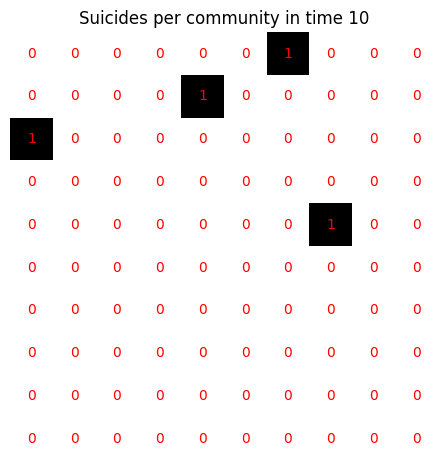

In [145]:
harvest = xd[0][129]

fig, ax = plt.subplots()
im = ax.imshow(harvest, cmap= 'binary')


# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, int(harvest[i, j]),
                       ha="center", va="center", color="r")

ax.set_title("Suicides per community in time 10")
ax.axis('off')
# Add a colorbar (legend)
# cbar = fig.colorbar(im, ax=ax)
fig.tight_layout()
plt.show()